# Lecture 4: Time Series Analysis

Time series analysis is a very useful tool in financial engineering, especially when trying to extract a trend out of a stochastic process, calculate a smooth series (such as those "indicators" eg. SMA, EMA, etc), and forecast future developements of a time series. This notebook should hopefully cover all of these tasks and beyond. 

The main topics of discussion are:

 1. Introduction to TSA
 2. Characteristics of time series
 3. Selected time series models
 4. Model Diagnostics
 5. Volatility Forecasting
 



In [1]:
#Importing standard libraries


import numpy as np
from matplotlib import pyplot as plt 
import scipy as sci
import pandas as pd

## Introduction to Time Series Analysis

A time series $(Y_t)_{t \geq 0} = (\dots,Y_{-2},Y_{-1},Y_0,Y_1,Y_2, \dots)$ is defined as a realization of a stochastic process at equidistantly spaced points in time. A univariate time series can be described by a sequence $(y_1,y_2,\dots,y_T)$ or in short $(y_t)^T_{t = 1}$. The random variable $Y_t$ is assumed to be metric and the process is assumed to be stationary (invariant under a time transformation $t \rightarrow t+h$, where $h$ is a lag).

By looking at, say, the SP500 index chart in a multi-decade long timeframe, one can see that there are trends, cycles, seasonalities, etc. This is why it makes sense to use TSA to study financial data. One can then study the volatilities in various seasons, etc.


The standard models of a time series assume additive components such as trends, cycles, seasonalities, etc as well as a stochastic component. The simplest trend model one could think of is the following:

$$y_t = d_t + u_t$$

where $d_t$ is some deterministic trend and $u_t$ being a stochastic stationary factor (usually assumed to be _white noise_, or $u_t \sim N(0,\sigma^2)$)


#### Python Implementation

Say we have a linear trend $d_t = x$ and gaussian noise as a stochastic factor $u_t \sim N(0,1)$. We could then model the time series $y_t$ as follows:

In [2]:
T = range(0,40) #time

d_t = T #trend 

y_t = [i + np.random.normal(0,1) for i in T] #time series


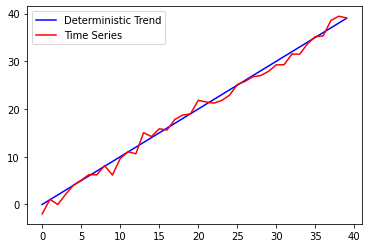

In [3]:
plt.plot(T,d_t,color='blue',label='Deterministic Trend')
plt.plot(T,y_t,color='red',label='Time Series')
plt.legend()

The example above is likely the simplest possible model, although one can make it additive by adding seasonal factors and cycles (think, sine function for example). The result will be 

$$y_t = d_t + s_t + u_t$$

where $s_t$ represent a seasonal component. 


As mentioned informally in the very top of this notebook, a typical goal in TSA is to extract $d_t$ and $s_t$ out of $y_t$. This could be achieved by

 1. Calculating the estimates $\hat{d_t}$ and $\hat{s_t}$
 2. Calculating the time series of the residuals as $\hat{u_t} = y_t - \hat{d_t} -\hat{s_t}$
 
If $\hat{u_t}$ then satisfies assumptions (i.e $\hat{u_t} \sim WN(\mu,\sigma^2)$), then the estimates are accurate. If it is not accurate, then there is likely some error in $\hat{d_t}$ and/or $\hat{s_t}$.


Another way to "detrend the model" is to apply what is known as the _lag operator_ $\tilde{y_t}$. For a linear trend (such as the example above), the lag operator should simply be

$$\tilde{y_t} = y_t - y_{t - 1}$$


#### Python Implementation 

Say 

$$y_1 = t + s_t$$

and 

$$y_2 = (t + 1) + s_t$$

Let us try to apply a lag operator

Mu = 1.0564876052571035, Sigma^2 = 2.017803092204495


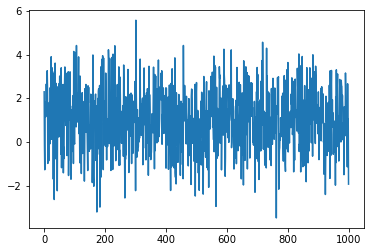

In [4]:
T = range(0,1000) #time



y_1 = np.array([i + np.random.normal(0,1) for i in T])
y_2 = np.array([i + 1 + np.random.normal(0,1) for i in T])


lag_op = y_2 - y_1 

plt.plot(T,lag_op)
print("Mu = "+str(np.mean(lag_op))+", Sigma^2 = "+str(np.std(lag_op)**2))

Let us now try compare the histogram data of `lag_op` to the normal distribution with the parameters given above (mu and sigma\*\*2), and then test for normality using the Jarque-Berat test with a standard 5\% tolerance. 

p-value: 0.19648150247477847 which is much higher than 0.05, rendering the test positive.


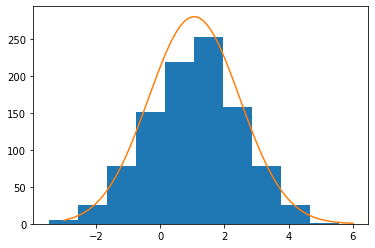

In [5]:
from scipy.stats import norm
plt.hist(lag_op)#histogram
plt.plot(np.linspace(-3,6,10000),[1000*norm.pdf(i,np.mean(lag_op), np.std(lag_op)) for i in np.linspace(-3,6,10000)])

JB_test = sci.stats.jarque_bera(lag_op)

print('p-value: '+str(JB_test.pvalue)+" which is much higher than 0.05, rendering the test positive.")




as you can see, it passes the normality test and fits the distribution, thus proving the lag operator $\tilde{y_2}$ produces white noise. 

To determine the trendline of a time series, one either employs _moving averages_ of order $q$, which takes the following form:

$$\hat{d_t} = \hat{\beta_1}y_{t - 1} + \hat{\beta_2}y_{t - 2} + \dots + \hat{\beta_q}y_{t - q} = \sum_{i = 1}^q \hat{\beta_i}y_{t - i}$$

or _polynomial fitting_ of order $q$, which takes the form

$$\hat{d_t} = \hat{\beta_0} + \hat{\beta_1}t + \hat{\beta_2}t^2 + \dots + \hat{\beta_q}t^q = \sum_{i = 0}^q \hat{\beta_i}t^i$$

#### Python Implementation

We will try to fit a polynomial model of order 5 to \$GOOG price data from 2016 to 2021.


In [6]:
from pandas_datareader import data ## This import allows us to import stock price data from yahoo finance

def get_stock_price(ticker, start='2016-01-01', end='2020-12-31',price_type = 'Adj Close'): ##function from lecture 1
    return data.DataReader(ticker,'yahoo',start,end)[price_type]

data = list(get_stock_price('GOOG')) #google price data as a list



In [7]:
q_eq_5 = lambda t,a,b,c,d,e,f: a + b*t + c*(t**2) + d*(t**3) + e*(t**4) + f*(t**5) #polynomial function where q=5

model = sci.optimize.curve_fit(q_eq_5,list(range(len(data))),data) #estimated beta values (params of best fit)

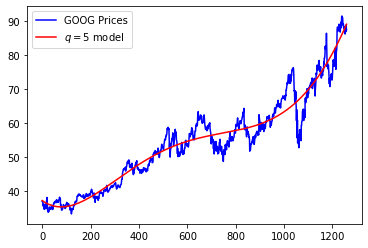

In [8]:
plt.plot(data,color='blue',label='GOOG Prices') #plotting stock data
plt.plot([q_eq_5(i,*model[0]) for i in range(len(data))],color='red',label=r'$q = 5$ model') #plotting the model
plt.legend()

As you can see, the model, whilst doesn't capture the noise, follows the trend of the data very well. Another useful thing to do would be plot the residuals in a histogram (which represents the probability distribution of the price being a value $\eta = y_t - \hat{y_t}$ away from the trendline).

(array([ 19.,  32., 110., 308., 436., 252.,  66.,  21.,   7.,   8.]),
 array([-10.88832358,  -8.38953926,  -5.89075495,  -3.39197063,
         -0.89318631,   1.605598  ,   4.10438232,   6.60316663,
          9.10195095,  11.60073526,  14.09951958]),
 <BarContainer object of 10 artists>)

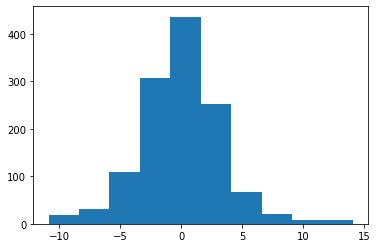

In [9]:
resid = np.array([q_eq_5(i,*model[0]) for i in range(len(data))]) - np.array(data) #eta values

plt.hist(resid)

Where one could refer to Lecture 2 to fit this data into an appropriate distribution. 

To learn to employ moving averages in python, one can watch [this video](https://www.youtube.com/watch?v=I6ZBJo_xt2I)!




## Characteristics of Time Series

A time series $Y_t$ can be characterized by a function of expectation values

$$\mu(t) = \mathbb{E}(Y_t)$$

a covarariance function

$$\gamma(t, t+k) = Cov(Y_t,Y_{t+k}) \\ = \mathbb{E}\left((Y_t - \mu_t)(Y_{t + k} - \mu_{t + k})\right)$$

and an autocorrelation function

$$\rho(t, t+k) = \frac{Cov(Y_t,Y_{t+k})}{\sqrt{Var(Y_t)\sqrt{Var(Y_{t+k})}}} \\ = \frac{\gamma(Y_t,Y_{t+k})}{\sqrt{\gamma(t,t)}\sqrt{\gamma(t+k,t+k)}}$$

as per the definitions laid out in Lecture 1.

#### Weak Stationary Time Series

A weakly stationary time series is any time series that has the following characteristics:

 1. $\mu(t) = \mu \in \mathbb{R}$
 2. $\gamma(t, t+k) = \mu(k)$
 3. $\rho(t, t+k) = \rho(k) = \frac{\gamma(k)}{\gamma(0)}$
 
 
 In other words, a time series with constant expected value and with covariance and autocorrelation functions that depends soley on the lag $k$.
 
 
**Example:**

Let us consider a time series such that

$$Y_0 = 0$$
and 
$$Y_{t+1} = Y_t + u_t$$

where $u_t \sim N(0,\sigma^2)$ is assumed to be white noise. Such a process is called a random walk, and our goal here is to find out whether they are a stationary time sreries or not.


##### First let us implement it in Python

In [10]:
def random_walk(sigma=1,n=100):
    Y = np.zeros(n) #initializing the time series 
    Y[0] = 0 #making it explicit that Y_0 = 0
    
    for t in range(n-1):
        Y[t+1] = Y[t] + np.random.normal(0,sigma) #Y_t+1 depends on Y_t and some white noise
    return Y

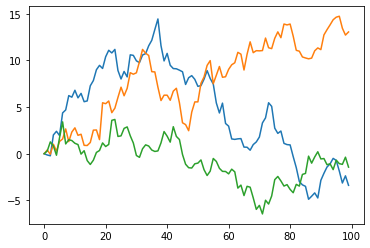

In [11]:
for i in range(3):
    plt.plot(random_walk())

A keen reader may realize such a process, as it is a general case of the result of the coin game in lecture 2! (The only difference being that we were constrained to -1 and 1 in the coin game).

Remember, a key condition for a time series to be weakly stationary is that $\gamma(t,t)$ depends only on the lag $k$. Let us see if that is the case:

$$Y_t = Y_{t - 1} + u_t \\ = (Y_{t - 2} + u_{t-1}) + u_t \\ = (Y_{t - 3} + u_{t-2}) + u_{t-1}) + u_t \\ = \dots \\ = Y_{0} + \sum_{i = 1}^t u_i$$


In other words, a random walk is $Y_t$ is nothing but its initial conditions $Y_0 = 0$ plus a set of $t$ normally distributed random numbers (white noise). With that, we can say


$$\gamma(t,t) = Var(Y_t) \\ = Var(Y_0 + \sum_{i = 1}^t u_i) \\ = Var(\sum_{i = 1}^t u_i)$$

which, according to [Bienaymé's Equation](https://stats.stackexchange.com/questions/31177/does-the-variance-of-a-sum-equal-the-sum-of-the-variances), gives

$$\gamma(t,t) = \sum_{i = 1}^t Var(u_i)$$

which, because $Var(u_i) = \sigma^2$, gives us

$$\gamma(t,t) = \sigma^2t$$

In other words, $\gamma(t,t)$ clearly depends on $t$ for the random walk, rendering it not weakly stationary. 

<hr>

If a given time series is weakly stationary, we can estimate the autocorrelation function $\hat{\rho}(k)$ as

$$\hat{\rho}(k) = \frac{\sum_{t=1}^{T - k}(Y_{t+k} - \bar{y})(y_t - \bar{y})}{\sum_{t = 1}{T} (y_t - \bar{y})^2}$$


which can be graphically represented by a _correlogram_, which plots the $\rho(k)$ vs $k$.

#### Python Implementation

First we will plot the correlogram using the `statsmodels` library for a random walk with 50 steps. We will then do the same for SP500 prices

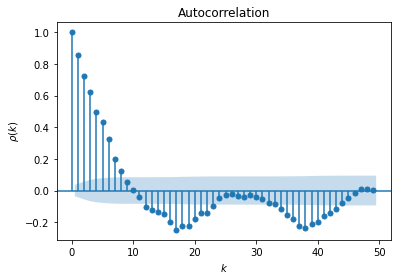

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

random_walk_path = random_walk(n=50) #randomwalk with sigma = 1 (default of function) and 50 steps

plot_acf(random_walk_path, lags=49,alpha=0.8) #correlogram with alpha of 0.8 -- alpha = 1 - confidence level

plt.xlabel(r'$k$')
plt.ylabel(r'$\rho(k)$')
plt.show() #just a technicality so the graph doesn't show twice

As you can see we get the graph expected -- the blue region indicates the confidence interval (i.e everything inside of it is statistically insignificant).

Let us return the same plot but for the SPY data from 2020 to 2022 using a single day as a lag period.

In [13]:
from pandas_datareader import data ## This import allows us to import stock price data from yahoo finance

sp500_data = get_stock_price('SPY', start='2020-01-01',end='2022-01-01')

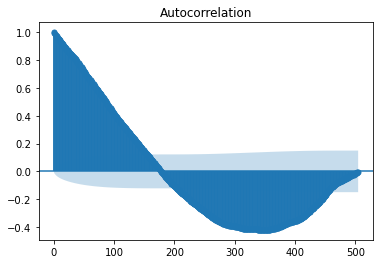

In [14]:
plot_acf(sp500_data,lags=len(sp500_data)-1,alpha=0.8) #using daily lag data
plt.show()

All ACF plots are initialized at 1 because $\rho(0) = Corr(y_0,y_0) = 1$


<br>

## Selected Time Series Models

Before going through complicated multivariate time series models, let us go through a few univariate ones, such as Moving Averages.

The _simple moving average_ (SMA) is defined as the unweighted mean of the previous $n$ datapoints, or

$$\tilde{y_t} = \frac{1}{n}\sum_{k=0}^{n-1}y_{t - k}$$ where $t = n, n+1, n+2,\dots$

As the following image will show, the larger $n$ is, the more smooth the SMA is:

<img src="assets/enoughindicators.png">

The top of the image shows the number of datapoints that are considered in the SMA. For example, SMA120 will have 120 weeks while the SMA5 will have 5 weeks (this is a weekly chart for ETHUSD). As you can see the larger the timeframe considered, the smoother the curve.

<hr>

### ARMA Models

Say we have a time series with $\mu = 0$. One way to model this time series is with 

$$y_t = \alpha_1y_{t - 1} + \alpha_2y_{t - 2} + \dots + \alpha_py_{t - p} + u_t = u_t + \sum_{i=1}^p \alpha_iy_{t - i}$$

where $u_t$ is assumed to be a white noise process. This is called an autoregressive model of order $p$, $AR(p)$ (where $p$ is the number of datapoints considered). An $AR(p)$ model is stationary if the absolute value of every root of the polynomial $P(\lambda) = 1 - \alpha_1\lambda - \alpha_2\lambda^2 - \dots - \alpha_p\lambda^p$ is greater than 1. Although, for very large numbers of $p$, this is hard to verify. 

Remember that a Moving Average of Process order q $MA(q)$ could be represented by 

$$y_t = \beta_1u_{t - 1} + \beta_2u_{t - 2} + \dots + \beta_qu_{t - q} + u_t = u_t + \sum_{i=1}^q \beta_iu_{t - i} $$

where $u_{t - i}, i=0,1,2\dots,q$ are white noise processes. 


An $AR(p)$ model could be combined with a $MA(q)$ model to become an autoregressive moving average model, or $ARMA(p,q)$, which takes the following form:

$$ARMA(p,q) = \alpha_1y_{t - 1} + \alpha_2y_{t - 2} + \dots + \alpha_py_{t - p} + u_t + \beta_1u_{t - 1} + \beta_2u_{t - 2} + \dots + \beta_qu_{t - q} = u_t + \sum_{i=1}^p \alpha_iy_{t - i} + \sum_{i=1}^q \beta_iu_{t - i}$$

This proces is stationary if the $AR$ part of the model is stationary (which could be determined from the condition mentioned above).  


The parameters necessary to model a time series with $ARPA(p,q)$ could be determined using the Box-Jenkins method:

 1. After removing the trend and seasonal component (applying a lag operator), the order (p,q) can be determined based on the values of autocorrelation function and the _partial autocorrelation function_
 2. Estimation of the model parameters $(\alpha_0, \dots, \alpha_p, \beta_1,\dots,\beta_q)$ can be determined using something like maximum likelihood estimation or least squares method.
 3. Residual Analysis: the residuals are supposed to be uncorrelated and have constant $\mathbb{E}$ and $Var$ over time. To check for this, one can look at autocorrelation and partial autocorrelation, or use the [Durbin-Watson Test](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp)
 
 
One can now use this estimated model to try and forecast future values of $\mathbb{E}(y_t)$ given $y_1,y_2,\dots,y_{t-k}, k \geq 1$.

### ARCH Models

One of the most commonly used models for daily risk factor returns is the $ARCH(p)$ model (Autoregressive Conditional Heteroscedasticity), as well as its generalized counterpart. An ARCH  is defined as follows:

 - $(X_t)_{t\in \mathbb{Z}}$ is an ARCH(p) process if it is strictly stationary and satisfies the following:
 
 $$X_t = \sigma_tZ_t$$
 and 
 $$\sigma_t^2 = \alpha_0 + \sum_{k=1}^p\alpha_kX^2_{t - k}$$
 
 where $(Z_t)_{t \in \mathbb{Z}}$ follows a white noise process with $\mathbb{E}(Z_t) = 0$ and $Var(Z_t) = 1$, and $\alpha_0 > 0, \alpha_k \geq 0$. The name should now make sense as it resembles an autoregressive model (AR) and the variance is non-constant and dependent on the previous $X_k$ values (CH). As the definition suggests, the ARCH model assumes a variance that is a continuously changing function proportional to the previous $p$ values of the process.
 
 
### GARCH Model

The GARCH model, or generalized ARCH model is another model that is useful for daily risk-factor returns. It is defined as follows:

$(X_t)_{t \in \mathbb{Z}}$ is a GARCH(p,q) process if it is strictly stationary and

$$X_t = \sigma_t Z_t$$
and
$$\sigma_t^2 = \alpha_0 + \sum_{i = 1}^p \alpha_iX^2_{t-i} + \sum_{j = 1}^q \beta_j\sigma^2_{t-j}$$

where $\alpha_0 > 0, \alpha_i \geq 0, \beta_j \geq$ and, again, $(Z_t)_{t \in \mathbb{Z}}$ follows a strict which noise process with $\mathbb{E}(Z_t) = 0$ and $Var(Z_t) = 1$. In other words, it is similar to an ARCH(P) model with the difference being that the volatility is not only dependent on the previous values of the process but also the previous volatility (or rather, their squares). 

It can be trivially be shown that $GARCH(p,0) = ARCH(0)$. Also, in practice low values of p and q suffice to model a financial time series. A common example is $GARCH(1,1)$.


By setting the $ARMA$ error equal to $\sigma_tZ_t$, where $\sigma_t$ follows the GARCH model (see eq above), we get $ARMA(p,q)-GARCH(P,Q)$, a very flexible model family that is useful to us in QRM as it combines the properties of both model classes.

**GARCH Extensions:** Examples include

 - Exponential GARCH (EGARCH)
 - Glosten-Jagannathan-Runkle GARCH (GJR-GARCH)
 - Threshold GARCH (TGARCH)
 - Asymmetric power GARCH (AGARCH)

I will not elaborate on these models but have included an html file that does on the "Further Reading" folder.


#### Python Implementation

A useful library for time series analysis is the `arch` library, which one can install by uncommenting the following block:

Note to adam: 
 - Do GARCH(3,0) = ARCH(3) for \$SM volitility forcasting
 - Do ARMA for price forcasting (try to outperform benchmarks)

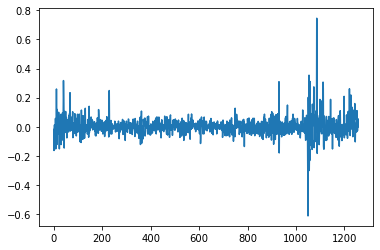

In [126]:
XOM_price = np.array(get_stock_price('SM'))
XOM_returns = [(XOM_price[i+1] - XOM_price[i])/XOM_price[i] for i in range(len(XOM_price) - 1)]
plt.plot(XOM_returns)

## Multivariate Volatility Models

The previous sub-section went through univariate volatility models such as ARCH and GARCH, where the starting point to modeling volatilities was the following:

$$Y_t = \sigma_tZ_t$$

where $Y_t$ is a time series (typically representing returns), $\sigma_t$ is the conditional volatilities and $Z_t$ is some random process. 

Now we will consider the multivariate case (namely, the case with $K$ given securities) with a conditional volatility vector $\vec{\sigma_t} = \{\sigma_{t1}, \dots,\sigma_{tk}\}$. In this case, we now represent the process as

$$Y_{ti} = \sigma_{ti}Z_{ti}$$

where $i \in \{1,\dots,K\}$


The conditional covariance matrix of returns is given by $\mathbf{\Sigma_t}$ with entries $Cov(Y_{ti},Y_{tj}) = \sigma_{t,ij}$ 

### EWMA

The Exponentially Weighted Moving Average model is a very simple model in the context of multivariate volatility modeling. It assigned exponentially decreasing weights to previous datapoints in the time series. That is, more recent data is weighed exponentially more than older ones.


The univariate EWMA is described by the following variant:

$$\hat{\sigma_t}^2 = \lambda\hat{\sigma}_{t - 1}^2 + (1 - \lambda)y^2_{t-1}$$

with a known assumed weight $\lambda$

The multivariate generalization is described by the following:

$$\hat{\mathbf{\Sigma}}_t^2 = \lambda \hat{\mathbf{\Sigma}}_{t-1}^2 + (1 - \lambda)y^T_{t-1}y_{t-1}$$

where $y_{t-1}^T$ denotes the transpose of $y_{t-1}$. It could also be done by seperate entries of $\hat{\mathbf{\Sigma}_t}$ as follows:

$$\hat{\sigma}_{tij}^2 = \lambda \hat{\sigma}_{(t-1)ij}^2 + (1 - \lambda)y_{(t-1)i}y_{(t-1)j}$$

<hr>

Before going through more complicated multivariate volatility models, it is first important to define multivariate white noise.

 - $\{X_t\}_{t \in \mathbb{Z}}$ is a multivariate white noise process if it produces a series of iid vectors. 
 
  
For a multivariate white noise process $X_t \sim WN(\vec{0}, \mathbf{\Sigma})$ , there is no cross-correlation between any components of the series for lag greater than zero.


Another thing that is worth defining is strict stationarity in a multivariate context, which is trivially:

 - A multivariate time series $\{X_t\}_{t \in \mathbb{Z}}$ is strictly stationary if $(X_{t_1}, X_{t_2}, \dots, X_{t_n}) \sim (X_{t_1 + k}, X_{t_2 + k}, \dots, X_{t_n + k})$ for all times $t$ and all lags $k$.
 
### VARMA Models

The Vector AutoRegressive Moving Average model is a multivariate generalization of the ARMA model covered above. In practice, the most common usage of this model is simply the VAR(p) model, which when p=1, gives

$$X_t = \mathbf{\Phi} X_{t - 1} + \epsilon_t$$


where $\{\epsilon_t\}$ follows a white noise process and $\mathbf{\Phi} \in \mathbb{R}^{d \times d}$ is a time invariant matrix.

### Multivariate GARCH Model

Let $\{Z_t\}_{t \in \mathbb{Z}} \sim WN(\vec{0}, \mathbf{I_d})$ where $I_d$ represents a $d$ dimensional identity matrix. A process $\{X_t\}_{t \in \mathbb{Z}}$ is said to follow a GARCH(p,q) model if it is strictly stationary and has the form 

$$X_t = \mathbf{A}_tZ_t$$

given that $\mathbf{A} \in \mathbb{R}^{d \times d}$ is a matrix such that $A^TA = \mathbf{\Sigma}_t$, where $\mathbf{\Sigma}_t$ is the conditional covariance matrix.
 
 
 - Note that one can also add a conditional mean $\mu_t$ that can either be constant or likely follow a VARMA process. In other words

$$X_t = \mu_t + \mathbf{A}_tZ_t$$


 - Also, $\mathbf{\Sigma_t}$ could be written in terms of diagonal volatility matrix $\mathbf{\Delta_t}$ and conditional correlation matrix $\mathbf{P_t}$ as $\mathbf{\Sigma_t} = \mathbf{\Delta_t}\mathbf{P_t}\mathbf{\Delta_t}$
 - To describe $Z_t$, one can use any distribution with mean $\vec{0}$ and covariance matrix $\mathbf{I}_d$, although the standard is either a normal distribution or a $t$-distribution.

### CCC Model

The Constant Conditional Correlation (CCC) process is a special case of the GARCH model, where the conditional correlation matrix has a structure such that the conditional covarainces are proportional to the conditional volatilities. The structure of such a CC matrix $\mathbf{\hat{\Sigma}}_t$ ends up requiring a constant positive-definite correlation matrix $\mathbf{\hat{R}}_t$ and a diagonal volatility matrix $\mathbf{\hat{D}}_t$ where

$$\mathbf{\hat{\Sigma}}_t = \mathbf{\hat{D}}_t\mathbf{\hat{R}}_t\mathbf{\hat{D}}_t$$


where 

$$\mathbf{\hat{D}}_t = \begin{pmatrix}\hat{\sigma}_{t1} & 0 & 0 \\ 0 & \ddots & 0 \\ 0 & 0 & \hat{\sigma}_{tK}\end{pmatrix}$$


One can notice from $\mathbf{\hat{D}}_t$ that there are no correlations, i.e $\sigma_{tij} = 0$. In the markets, this is not always the case and usually requires something more sophisticated, such as the Dynamic Conditional Correlation model (DCC).


The estimation of $\mathbf{\hat{\Sigma}}_t$ can be performed by the following process:

 1. Fitting the univariate GARCH models to each component of the series (which can be used to form $\mathbf{\hat{D}}_t$)
 2. Forming Residuals $\mathbf{\hat{D}}_t^{-1}X_t$ and estimating $\mathbf{\hat{R}}_t$ using the standard correlation estimator.
 
 (verify this)
 
### DCC Model
